## Basis Expansions, Splines, Robust Regression


The demo illustrates:

* the drawbacks of modeling functions using polynomials
* regression splines as a nicer alternative
* the use of L1 regression with splines for robust fits

See [splinesP.ipynb](splinesP.ipynb) for some of these examples in python. See [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) Section 5.2 for a discussion of splines.

In [13]:
## load some data
library(L1pack)
library(splines)
library(data.table)

set.seed(1234)

## read data, order times, fold lc, put in x,y,sig variables
dat <- as.data.frame(fread("http://longjp.github.io/statcomp/lectures/star.dat"))
x <- dat[,1]
y <- dat[,2]
sig <- dat[,3]

Our goal is to model $y$ as a function of $x$. Clearly this is a nonlinear relationship.

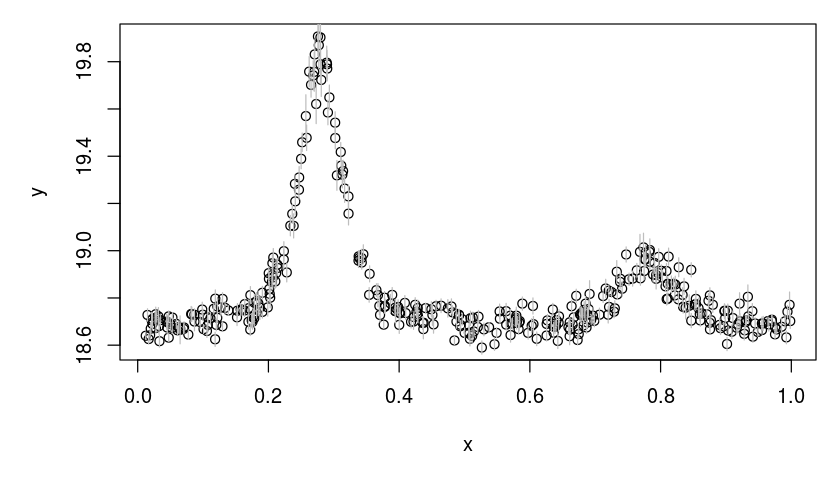

In [14]:
options(repr.plot.width=7,repr.plot.height=4)
par(mar=c(5,5,1,1))
plot(x,y,ylab="y",xlab="x")
segments(x,y + sig,x,y - sig,col='grey')

## Polynomial versus Spline Basis

One option is to represent y as a linear function of $x$, $x^2$, $x^3$, . . . i.e. as a polynomial of x up to some order. This does not work well for any reasonable order because:

* polynomials are not localized, e.g. the coefficient on $x^3$ affects the shape everywhere
* there is a high degree of correlation in the polynomials as the order increases, making it difficult to compute the LS fit, essentially the matrix $(X^TX)$ does not have full column rank.

We demostrate this issue now

In [40]:
## polynomial basis
p <- 6
X <- vapply(0:(p-1),function(y) x^y,rep(0,length(x)))
coeffs <- matrix(lm.fit(X,y)$coefficients,ncol=1)
## for p > about 15, some coefficients are NA, this is
## due to X being nearly column rank deficient which
## prevents lm.fit from finding a unique soln
print(sum(is.na(coeffs)))
coeffs[is.na(coeffs)] <- 0
preds <- X%*%coeffs

[1] 0


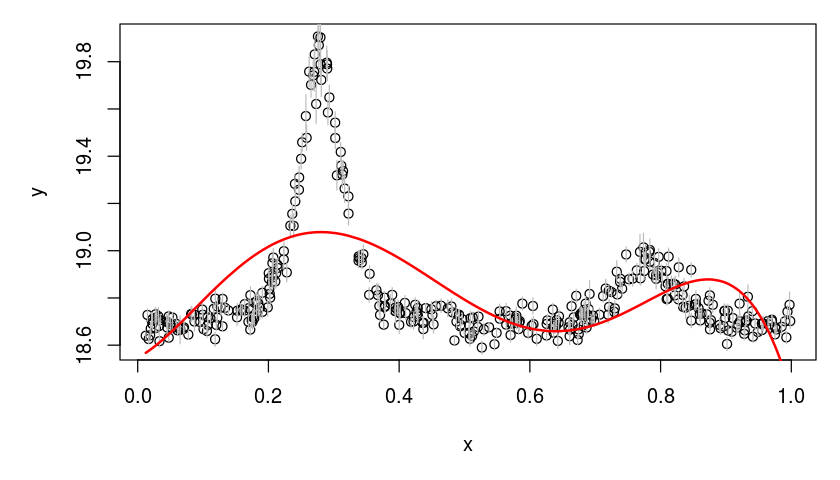

In [41]:
options(repr.plot.width=7,repr.plot.height=4)
par(mar=c(5,5,1,1))
plot(x,y,ylab="y",xlab="x")
segments(x,y + sig,x,y - sig,col='grey')
points(x,preds,col='red',type='l',lwd=2)

## Eigenvalues, Multicollinearity, Column Rank of Design Matrix $X$

The $X$ matrix is often called the design. If the $p$ columns of $X$ do not span a $p$ dimensional subspace of $n$, then $X^TX$ will not be of full rank (i.e. not invertible) and there will not be a unique solution to the normal equations. In particular $X^TX$ has $0$ eigenvalues. A similar phenomenon happens with polynomial bases where the matrix is "almost" not invertible. Essentially the smallest eigenvalues of $X^TX$ are almost $0$.

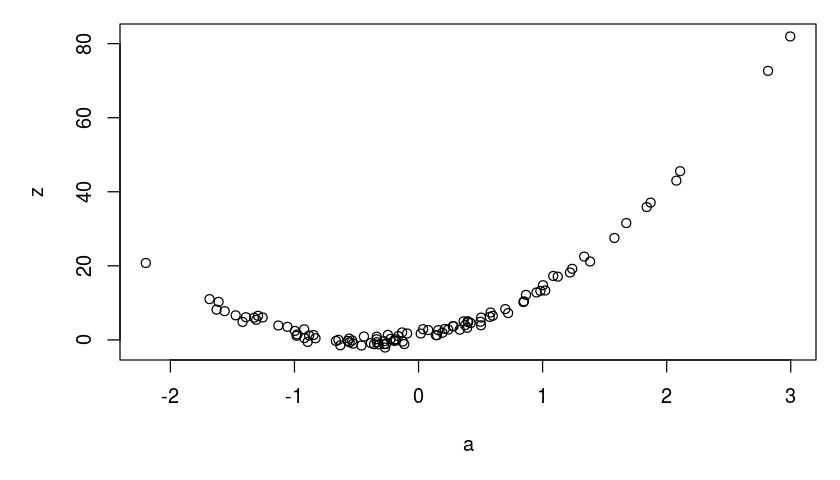

In [42]:
a <- rnorm(100)
A <- cbind(1,a,a^2,a+a^2)
colnames(A) <- c("1","x","x^2","x^2 + x")
z <- A%*%matrix(1:4,ncol=1) + rnorm(100)
par(mar=c(5,5,1,1))
plot(a,z)

In [43]:
lmf <- lm(z~A-1)
summary(lmf)



Call:
lm(formula = z ~ A - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.86127 -0.67476 -0.08071  0.63893  1.77840 

Coefficients: (1 not defined because of singularities)
         Estimate Std. Error t value Pr(>|t|)    
A1        0.91350    0.11050   8.267 7.25e-13 ***
Ax        6.02400    0.09599  62.757  < 2e-16 ***
Ax^2      6.98725    0.06380 109.521  < 2e-16 ***
Ax^2 + x       NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9045 on 97 degrees of freedom
Multiple R-squared:  0.9969,	Adjusted R-squared:  0.9968 
F-statistic: 1.029e+04 on 3 and 97 DF,  p-value: < 2.2e-16


In [44]:
## we can determine that some columns are functions of other columns
alias(lmf)

Model :
z ~ A - 1

Complete :
         A1 Ax Ax^2
Ax^2 + x 0  1  1   


## Local Polynomials

We fit local polynomials using our own basis functions. In practice it is better to use bsplines (see below) because they are optimized for speed and numberical stability.

In [45]:
range(x)

[1] 0.01237213 0.99832108

In [46]:
## creates a design matrix for local constant fitting
p <- 20 ## number of segments
breaks <- (1:p)/p


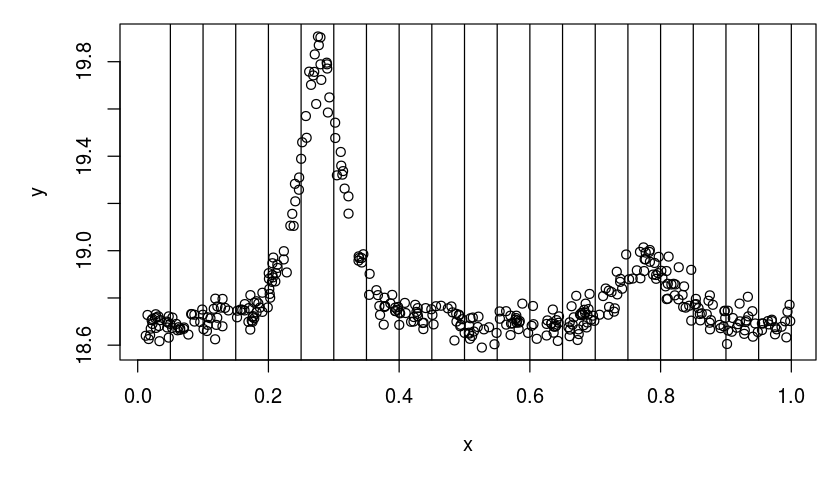

In [47]:
## idea: fit low degree polynomial regression separately to segments
options(repr.plot.width=7,repr.plot.height=4)
par(mar=c(5,5,1,1))
plot(x,y,ylab="y",xlab="x")
abline(v=breaks)


In [48]:
which_segment <- vapply(x,function(y) sum(y > breaks),0) + 1
basis <- diag(p)
X <- t(vapply(which_segment,function(y){basis[y,]},rep(0,p)))

In [25]:
dim(X)

[1] 378  20

In [26]:
## here linear model just takes average of values
## in segments defined by breaks
fit <- lm(y~X-1) 

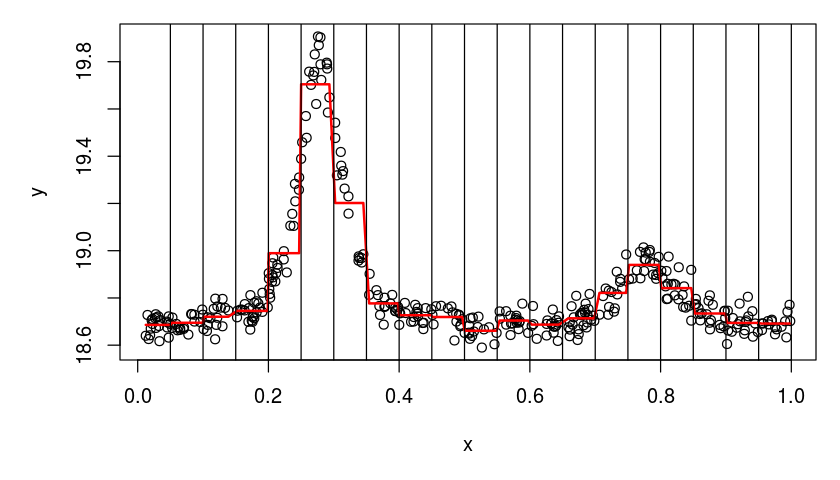

In [27]:
options(repr.plot.width=7,repr.plot.height=4)
par(mar=c(5,5,1,1))
plot(x,y,ylab="y",xlab="x")
points(x,fit$fitted.values,col='red',type='l',lwd=2)
abline(v=breaks)

In [28]:
X <- t(vapply(which_segment,function(y){basis[y,]},rep(0,p)))
X2 <- X*x

In [29]:
head(X)
head(X2)

1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


0.01237213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.01504452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.01676609,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.01895597,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.01997927,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0.02133762,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
X <- cbind(X,X2)


## fit piecewise linear
fit <- lm(y~X-1) 



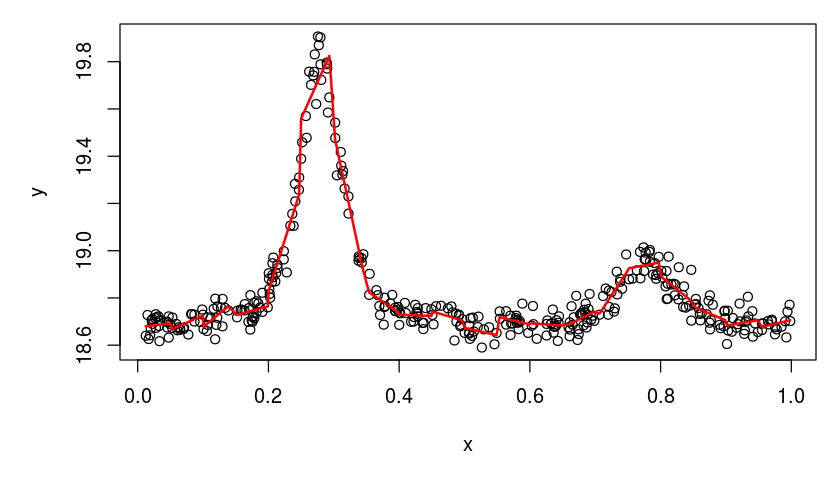

In [31]:
options(repr.plot.width=7,repr.plot.height=4)
par(mar=c(5,5,1,1))
plot(x,y,ylab="y",xlab="x")
points(x,fit$fitted.values,col='red',type='l',lwd=2)

## Splines

Splines fit local polynomials (usually degree 3) and ensure that at the breaks between polynomials, known as knots, the function remains smooth (usually twice continuously differentiable).

The popular splines basis, known as bSplines, is constructed in such a way as to ensure all eigenvalues of $X^TX$ remain reasonably large and that fitting is fast. The bSpline basis construction is more complex than other methods however.

In [32]:
## regression splines
N <- 30
X <- bs(x,knots=(1:N)/(N+1),intercept=TRUE)
coeffs <- matrix(lm.fit(X,y)$coefficients,ncol=1)
preds <- X%*%coeffs



In [33]:
dim(X)

[1] 378  34

In [34]:
## matrix is well conditioned
e <- eigen(t(X)%*%X)
e$values

[1] 14.1072229 13.7307266 12.5954586 11.1360445 10.6596928 10.5873646
 [7] 10.1582044  9.9775559  8.9330900  8.0292476  7.8435286  6.9788804
[13]  6.7996422  5.7923919  5.4873272  4.6728812  4.5264726  3.9873297
[19]  3.4594138  3.1207481  2.7541759  2.5582853  2.0491693  1.9163902
[25]  1.6880269  1.4433476  1.2653845  1.1326109  0.9385797  0.8096996
[31]  0.6503076  0.5847695  0.5265598  0.4508734

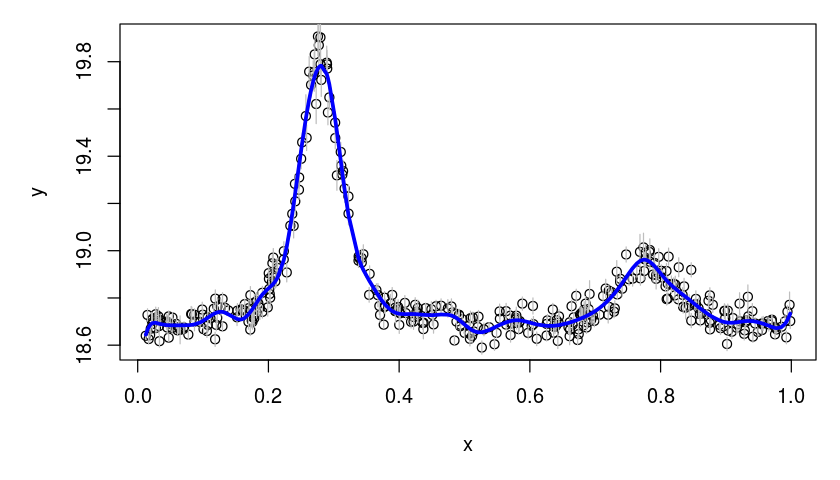

In [35]:
## should look much better than polynomial
par(mar=c(5,5,1,1))
plot(x,y,ylab="y",xlab="x")
segments(x,y + sig,x,y - sig,col='grey')
points(x,preds,col='red',type='l',lwd=2)
points(x,preds,col='blue',type='l',lwd=3)


## Robustness

The least squares fit above is not robust to outliers. Least absolute deviations is robust to outliers. We can easily fit the spline basis expansion with a L1 solver. This is an example of robust non-linear regression.

In [36]:
## add a large amount of error to p fraction of the observations
p <- 0.3
errs <- rbinom(length(x),prob=p,size=1)*rt(length(x),df=2)*0.3
ye <- y + errs

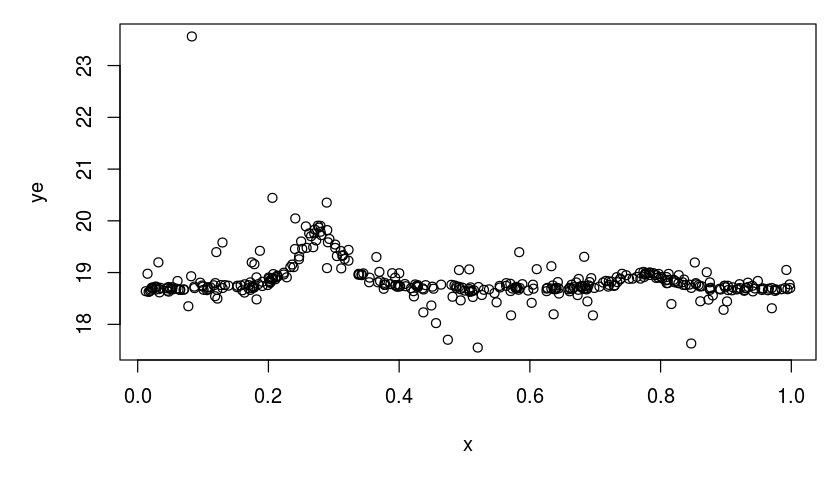

In [37]:
par(mar=c(5,5,1,1))
plot(x,ye)


In [38]:

## regression splines
N <- 30
X <- bs(x,knots=(1:N)/(N+1),intercept=TRUE)
coeffsLS <- matrix(lm.fit(X,ye)$coefficients,ncol=1)
predsLS <- X%*%coeffsLS
coeffsLAD <- l1fit(X,ye, intercept = FALSE)$coefficients
predsLAD <- X%*%coeffsLAD

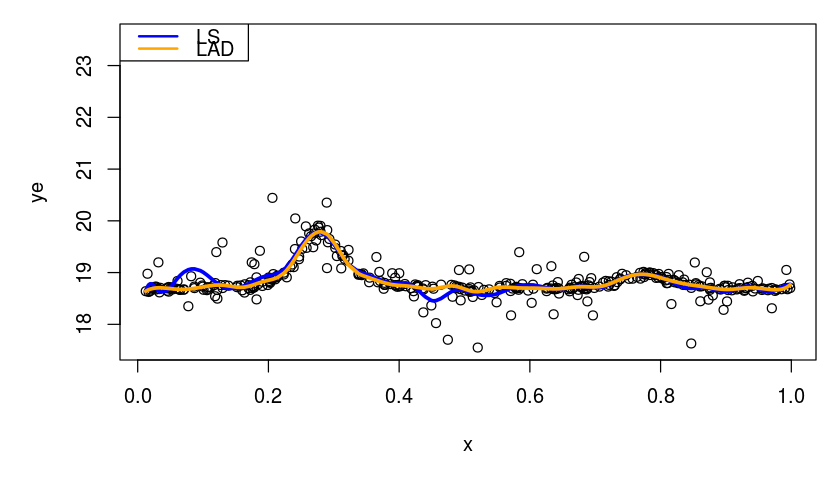

In [39]:
par(mar=c(5,5,1,1))
plot(x,ye)
points(x,predsLS,col='blue',type='l',lwd=3)
points(x,predsLAD,col='orange',type='l',lwd=3)
legend("topleft",c("LS","LAD"),col=c("blue","orange"),lwd=2)